# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

# Load Libraries

In [18]:
import h5py
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from scipy import stats
from bisect import bisect
import pandas as pd
from scipy.spatial import distance
print(os.listdir("./Input/train"))
print(os.listdir("./Input/test"))
# train_files = [name for name in os.listdir("./Input/train") if not name.endswith('DS_Store')]
# test_files = [name for name in os.listdir("./Input/test") if not name.endswith('DS_Store')]
# print(train_files)
# print(test_files)

['images_training.h5', 'labels_training.h5']
['.DS_Store', 'images_testing.h5', 'labels_testing_2000.h5']


# Load Data

In [19]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [20]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# Principal Component Analysis


<div style="text-align: right"> Sourced: https://stats.stackexchange.com/questions/125172/pca-on-train-and-test-datasets-should-i-run-one-pca-on-traintest-or-two-separa </div>
<div style="text-align: right"> https://towardsdatascience.com/pca-with-numpy-58917c1d0391 </div>
<div style="text-align: right"> https://stackoverflow.com/questions/10818718/principal-component-analysis </div>



## Computing the Eigenvectors and Eigenvalues


In [21]:
data = data_train
data = data - np.mean(data, axis=0)
print(data.shape)
covariance_matrix = np.cov(data.T)
#print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)
print("First 20 Eigenvalues: \n", eig_val[:20], "\n")

(30000, 784)
First 20 Eigenvalues: 
 [19.8611004  12.10997382  4.1078177   3.3719857   2.61461635  2.35693788
  1.61184549  1.28149922  0.92593176  0.89463432  0.67365696  0.62224642
  0.52434522  0.44943814  0.41495554  0.4023021   0.37964251  0.36276613
  0.31522305  0.31177036] 



## Picking Principal Components


In [22]:
variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)     
print("First 10 Variance Explained: \n", variance_explained[:10], "\n") 

cumulative_variance_explained = np.cumsum(variance_explained)
print("First 10 Cummulative Variance Explained: \n", cumulative_variance_explained[:10], "\n") 

First 10 Variance Explained: 
 [29.077053310731294, 17.72924699012503, 6.013928330120427, 4.936655363514209, 3.8278512994969107, 3.4506048031981504, 2.3597744497586266, 1.876140819639972, 1.3555828542550032, 1.309762764368793] 

First 10 Cummulative Variance Explained: 
 [29.07705331 46.8063003  52.82022863 57.75688399 61.58473529 65.0353401
 67.39511455 69.27125537 70.62683822 71.93660099] 



### Plot Cumulative explained variance to find elbow point

187


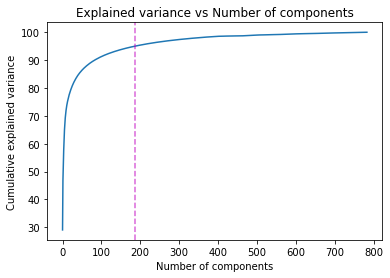

In [23]:
comp = bisect(cumulative_variance_explained, 95) #Number of components at 95% explained variance
sns.lineplot(x = np.arange(data.shape[1]), y=cumulative_variance_explained)
plt.axvline(comp, c='m', linestyle='--', alpha=0.6)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
print("Number of components for 95% Explained Variance:", comp)

## Project Data Onto Lower-Dimensional Linear Subspace

### Project onto training data

In [24]:
n_component = comp
projection_matrix = (eig_vec.T[:][:n_component]).T
X_train_pca = data.dot(projection_matrix)

print(X_train_pca.shape)

(30000, 187)


### Project on to test data

In [25]:
data = data_test
data = data - np.mean(data, axis=0)
X_test_pca = data.dot(projection_matrix)

print(X_test_pca.shape)

(5000, 187)


# kNN Classification Model
<div style="text-align: right"> Sourced: COMP5318 Tutorial 5 - Classification I </div>

In [26]:
def calc_knn1(X, y, K, X_q):
    dis = ((X - X_q)**2).sum(axis=1) #calculate distance between X_q and each training point
    arg_ascending = np.argsort(dis)
    
    classes = np.zeros(10)
    for i in range(K):
        classes[y[arg_ascending[i]]]+= 1
    return np.argmax(classes)

In [27]:
def calc_knn(X, y, K, X_q, distance_method):
    if distance_method == "squared" :
        dis = ((X - X_q)**2).sum(axis=1) #calculate distance between X_q and each training point
    elif distance_method =='euclidean':
        dis = np.sqrt(((X - X_q)**2).sum(axis=1))
    elif distance_method == "manhattan":
        dis = (X - X_q).sum(axis=1)
    else:
        raise ValueError('Undetermined distance')
    arg_ascending = np.argsort(dis)
    return stats.mode(y[arg_ascending[:K]]).mode

In [28]:
def calc_knn_sqaured(X, y, K, X_q):
    dis = ((X - X_q)**2).sum(axis=1) #calculate distance between X_q and each training point
    arg_ascending = np.argsort(dis)
    return stats.mode(y[arg_ascending[:K]]).mode

In [29]:
def calc_knn_euclidean(X, y, K, X_q):
    dis = np.sqrt(((X - X_q)**2).sum(axis=1)) #calculate distance between X_q and each training point
    arg_ascending = np.argsort(dis)
    return stats.mode(y[arg_ascending[:K]]).mode

In [30]:
def calc_knn_manhattan(X, y, K, X_q):
    dis = (X - X_q).sum(axis=1) #calculate distance between X_q and each training point
    arg_ascending = np.argsort(dis)
    return stats.mode(y[arg_ascending[:K]]).mode

In [31]:
def calc_knn_canberra(X, y, K, X_q):
    print(X_q.shape)
    dis = distance.cdist(X, X_q, 'canberra', p=X.shape[0]) #calculate distance between X_q and each training point
    arg_ascending = np.argsort(dis)
    return stats.mode(y[arg_ascending[:K]]).mode

In [32]:
def get_accuracy(pred, true):
    return np.sum(true == pred)/len(true)

# Split Data
Split training data into train and validaiton sets on 70:30

In [33]:
train_pct_index = int(0.7 * X_train_pca.shape[0])
print(train_pct_index)
X_train, X_val = X_train_pca[:train_pct_index], X_train_pca[train_pct_index:]
y_train, y_val = label_train[:train_pct_index], label_train[train_pct_index:]
# print(np.sum(X_train_pca[:train_pct_index] == X_train)/len(X_train_pca[:train_pct_index]))
# print(X_train[1])
# print(X_test_pca[1])
print(np.all(X_train[:10] == X_train_pca[:10]))
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

21000
True
(21000, 187)
(9000, 187)
(21000,)
(9000,)


# Cross Validation
Find best k method

In [34]:
%%time
k_list = np.arange(7, 10)
score_list = []
for k in k_list:
    y_pred = np.empty((len(X_val)))
    print("neighbour", k)
    for i in range(len(y_val)):
        y_pred[i]= calc_knn_sqaured(X_train, y_train, k, X_val[i,:])
    score_list.append(get_accuracy(y_pred, y_val))  
score_list = np.array(score_list)
k = np.argmax(score_list)

neighbour 7
neighbour 8
neighbour 9
CPU times: user 7min 44s, sys: 1min 18s, total: 9min 3s
Wall time: 10min 3s


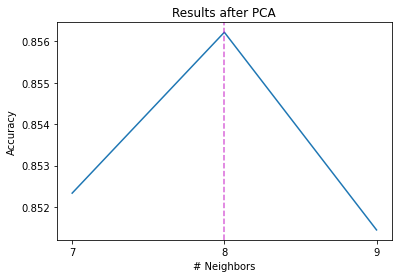

In [35]:
fig, ax = plt.subplots()
n_comp_list = np.arange(7, 10)
ax.plot(k_list, score_list)
ax.axvline(n_comp_list[np.argmax(score_list)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(k_list)
ax.set_title('Results after PCA')
plt.show()

In [36]:
# %%time
# k = 9
# distances = ["squared", "euclidean", "manhattan"]
# out_class = np.empty((len(X_val)))
# dis_accuracy = []
# for method in distances:
#     out_class = np.empty((len(X_val)))
#     for i in range(len(y_val)):
#         out_class[i] = calc_knn(X_train, y_train, k, X_val[i,:], method)
#     dis_accuracy.append(get_accuracy(out_class, y_val))

In [37]:
# %%time
# dis_accuracy = []
# out_class = np.empty((len(X_val)))
# for i in range(len(y_val)):
#     out_class[i] = calc_knn_sqaured(X_train, y_train, k, X_val[i,:])
# print(np.sum(y_val == out_class)/len(y_val))
# dis_accuracy.append(get_accuracy(out_class, y_val))


# y_true = y_val
# y_pred = out_class
# print(out_class.shape)
# pair = np.vstack((y_pred,y_true)).T
# pair = pair.astype(int)
# confusion_matrix = np.zeros((10,10))
# for i in pair:
#   confusion_matrix[i[1], i[0]] += 1
# print(confusion_matrix)

# np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

In [38]:
# %%time
# k=9
# out_class = np.empty((len(X_val)))
# for i in range(len(y_val)):
#     out_class[i] = calc_knn_euclidean(X_train, y_train, k, X_val[i,:])
# # print(out_class)
# # print(y_val)
# # print(np.sum(y_val == out_class)/len(y_val))
# dis_accuracy.append(get_accuracy(out_class, y_val))

# y_true = y_val
# y_pred = out_class
# print(out_class.shape)
# pair = np.vstack((y_pred,y_true)).T
# pair = pair.astype(int)
# confusion_matrix = np.zeros((10,10))
# for i in pair:
#   confusion_matrix[i[1], i[0]] += 1
# print(confusion_matrix)

# np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

# print(y_pred[:10])

In [39]:
# %%time
# out_class = np.empty((len(X_val)))
# for i in range(len(y_val)):
#     out_class[i] = calc_knn_manhattan(X_train, y_train, k, X_val[i,:])
# print(np.sum(y_val == out_class)/len(y_val))
# dis_accuracy.append(get_accuracy(out_class, y_val))



# y_true = y_val
# y_pred = out_class
# print(out_class.shape)
# pair = np.vstack((y_pred,y_true)).T
# pair = pair.astype(int)
# confusion_matrix = np.zeros((10,10))
# for i in pair:
#   confusion_matrix[i[1], i[0]] += 1
# print(confusion_matrix)

# np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

In [40]:
# %%time
# # out_class = np.empty((len(X_val)))
# # for i in range(len(y_val)):
# #     out_class[i] = calc_knn_canberra(X_train, y_train, k, X_val[i,:])
# # print(np.sum(y_val == out_class)/len(y_val))
# # dis_accuracy.append(get_accuracy(out_class, y_val))


# dis = distance.cdist(X_train, X_val, 'euclidean') #calculate distance between X_q and each training point
# arg_ascending = np.argsort(dis)
# print(arg_ascending)
# #out_class = stats.mode(y_train[arg_ascending[:]]).mode

# # y_true = y_val
# # y_pred = out_class
# # print(out_class.shape)
# # pair = np.vstack((y_pred,y_true)).T
# # pair = pair.astype(int)
# # confusion_matrix = np.zeros((10,10))
# # for i in pair:
# #   confusion_matrix[i[1], i[0]] += 1
# # print(confusion_matrix)

# # np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

In [41]:
# print(y_train[arg_ascending])

In [42]:
# q =stats.mode(y_train[arg_ascending]).mode[0,:]


In [43]:
# print(q.shape)
# print(y_val.shape)
# print(q[:5])
# print(y_val[:5])

In [44]:
# y_true = y_val
# y_pred = stats.mode(y_train[arg_ascending]).mode[0,:]
# pair = np.vstack((y_pred,y_true)).T
# pair = pair.astype(int)
# confusion_matrix = np.zeros((10,10))
# for i in pair:
#   confusion_matrix[i[1], i[0]] += 1
# print(confusion_matrix)

# np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

In [45]:
# dis_accuracy1 = np.asarray(dis_accuracy)
# print(dis_accuracy)
# print(dis_accuracy1)

# Calculate Test Dataset
<div style="text-align: right"> Sourced: COMP5318 Tutorial 5 - Classification I </div>


In [46]:
%%time
k = 9
out_class = np.empty((len(X_test_pca)))
for i in range(len(label_test)):
    out_class[i] = calc_knn_sqaured(X_train_pca, label_train, k, X_test_pca[i,:])

CPU times: user 44.2 s, sys: 7.46 s, total: 51.6 s
Wall time: 53.6 s


# Model analysis

In [47]:
y_true = label_test
y_pred = out_class[:y_true.shape[0]]

# pair = np.vstack((y_pred,label_test)).T
# pair = pair.astype(int)
# confusion_matrix = np.zeros((10,10))
# for i in pair:
#   confusion_matrix[i[1], i[0]] += 1
# print(confusion_matrix)

y_actu = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

np.sum(y_true == y_pred[:y_true.shape[0]])/len(y_true)

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
Actual                                                     
0          158    0    5    3    3    1   18    0    4    0
1            1  181    1    1    0    0    0    0    0    0
2            4    0  157    4   21    0   20    0    0    0
3            7    0    6  170   13    0    9    0    2    0
4            0    0   29   14  156    0   21    0    0    0
5            0    0    0    0    0  158    0   21    0   11
6           31    0   22    6   16    0  109    0    6    0
7            0    0    0    0    0    2    0  179    0   11
8            0    0    4    1    2    0    2    1  217    0
9            0    0    0    0    0    1    0    6    0  185


0.835